# Model Comparison: First Attempt

Previously, a hypothesis was made that models may perform better with aggregated prediction. After testing five models with the aggregated prediction approach (BERT excluded), Logistic Regression was found to perform best. Therefore, this notebook compares BERT with normal prediction against Logistic Regression with aggregated prediction to determine which yields superior performance.

Two ML models are compared in this notebook:
1. BERT transformer with BertTokenizer (Normal Prediction)
2. Logistic Regression with TfidfVectorizer (Aggregated Prediction)

## Setup

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import torch
from transformers import BertTokenizer, BertForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import joblib
import sys
sys.path.append('../scripts')  # add the 'scripts' directory to sys.path
from word_normalization import preprocess_text  # for customized preprocessing
from aggregated_prediction import get_aggregated_prediction  # for model evaluation for long sentences

C:\Users\ASUS\anaconda3\envs\hexsoftwares_ml_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f"CUDA version: {torch.version.cuda}")    
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f'Memory Usage: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

GPU: NVIDIA GeForce GTX 1060
CUDA version: 12.1
Number of GPUs: 1
Memory Usage: 6.00 GB
Using device: cuda


## Loading Test Datasets

In [3]:
df = pd.read_pickle('../datasets/final_testing_dataset.pkl')
df

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


In [4]:
df2 = pd.read_csv('../datasets/a2_RestaurantReviews_FreshDump.tsv', delimiter = '\t', quoting = 3)
df2 = df2.dropna()
df2['Review'] = df2['Review'].progress_apply(lambda x: preprocess_text(x))
df2

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 139.09it/s]


,Review,sentiment
0,spend money elsewher,0
1,regular toast bread equal satisfi occasion pat...,1
2,buffet bellagio far anticip,0
3,drink weak peopl,0
4,order not correct,0
...,...,...
95,think food flavor textur lack,0
96,appetit instantli go,0
97,overal not impress would not go back,0
98,whole experi underwhelm think well go ninja su...,0


## Loading Models

In [5]:
# model 1: BERT transformer with BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('../models/sentiment_analysis_bert_model_pytorch')
bert_model = bert_model.to(device)
bert_model.eval()  # set to evaluation mode

# model 2: logistic regression with TfidfVectorizer
logR = joblib.load("../models/sentiment_analysis_logr_model.joblib")

## Prediction on the First Test Dataset 

In [6]:
raw_X = df.review_text
raw_X

0       fantast spot even quit cocktail swell host yel...
1       love love love calamari good spici endless lis...
2       love place stiff martini cocktail cheap drink ...
3       everyth great cocktail bar great locat ambianc...
4       come pirat game around 530ish even get lucki t...
                              ...                        
4316    wife catch show golden nugget hear good thing ...
4317    dumb show ever seen never laugh minut realiz w...
4318    girlfriend go show absolut terriblenot funni n...
4319    restroom look like bombard improvis shack amid...
4320    go pennsylvania macaroni compani year love fre...
Name: review_text, Length: 4321, dtype: object

In [7]:
y_true = df.sentiment
y_true

0       1
1       1
2       1
3       1
4       1
       ..
4316    0
4317    0
4318    0
4319    0
4320    0
Name: sentiment, Length: 4321, dtype: int64

In [8]:
# function to predict with BERT in batches
def predict_bert_batch(texts, model, tokenizer, device, max_length=80, batch_size=32):
    """Predict sentiment for a batch of texts using BERT"""
    model.eval()
    predictions = []
    
    # process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="   BERT batches"):
        batch_texts = texts[i:i+batch_size]
        
        # tokenize batch
        encodings = tokenizer.batch_encode_plus(
            batch_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # move to device
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        
        # predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)
    
    return np.array(predictions)


# BERT transformer with BertTokenizer prediction
MAX_LENGTH = 80  # BERT max sequence length
BERT_BATCH_SIZE = 32  # process in batches to avoid memory issues

y_pred_bert = predict_bert_batch(
    raw_X.tolist(), 
    bert_model, 
    bert_tokenizer, 
    device, 
    max_length=MAX_LENGTH,
    batch_size=BERT_BATCH_SIZE
)

   BERT batches: 100%|███████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


In [9]:
# logistic regression with TfidfVectorizer prediction
y_pred_logr = []
for x in raw_X:  # use raw text, not vectorized
    y_pred_logr.append(get_aggregated_prediction(x, model=logR, model_name='logr'))

y_pred_logr = np.array(y_pred_logr)

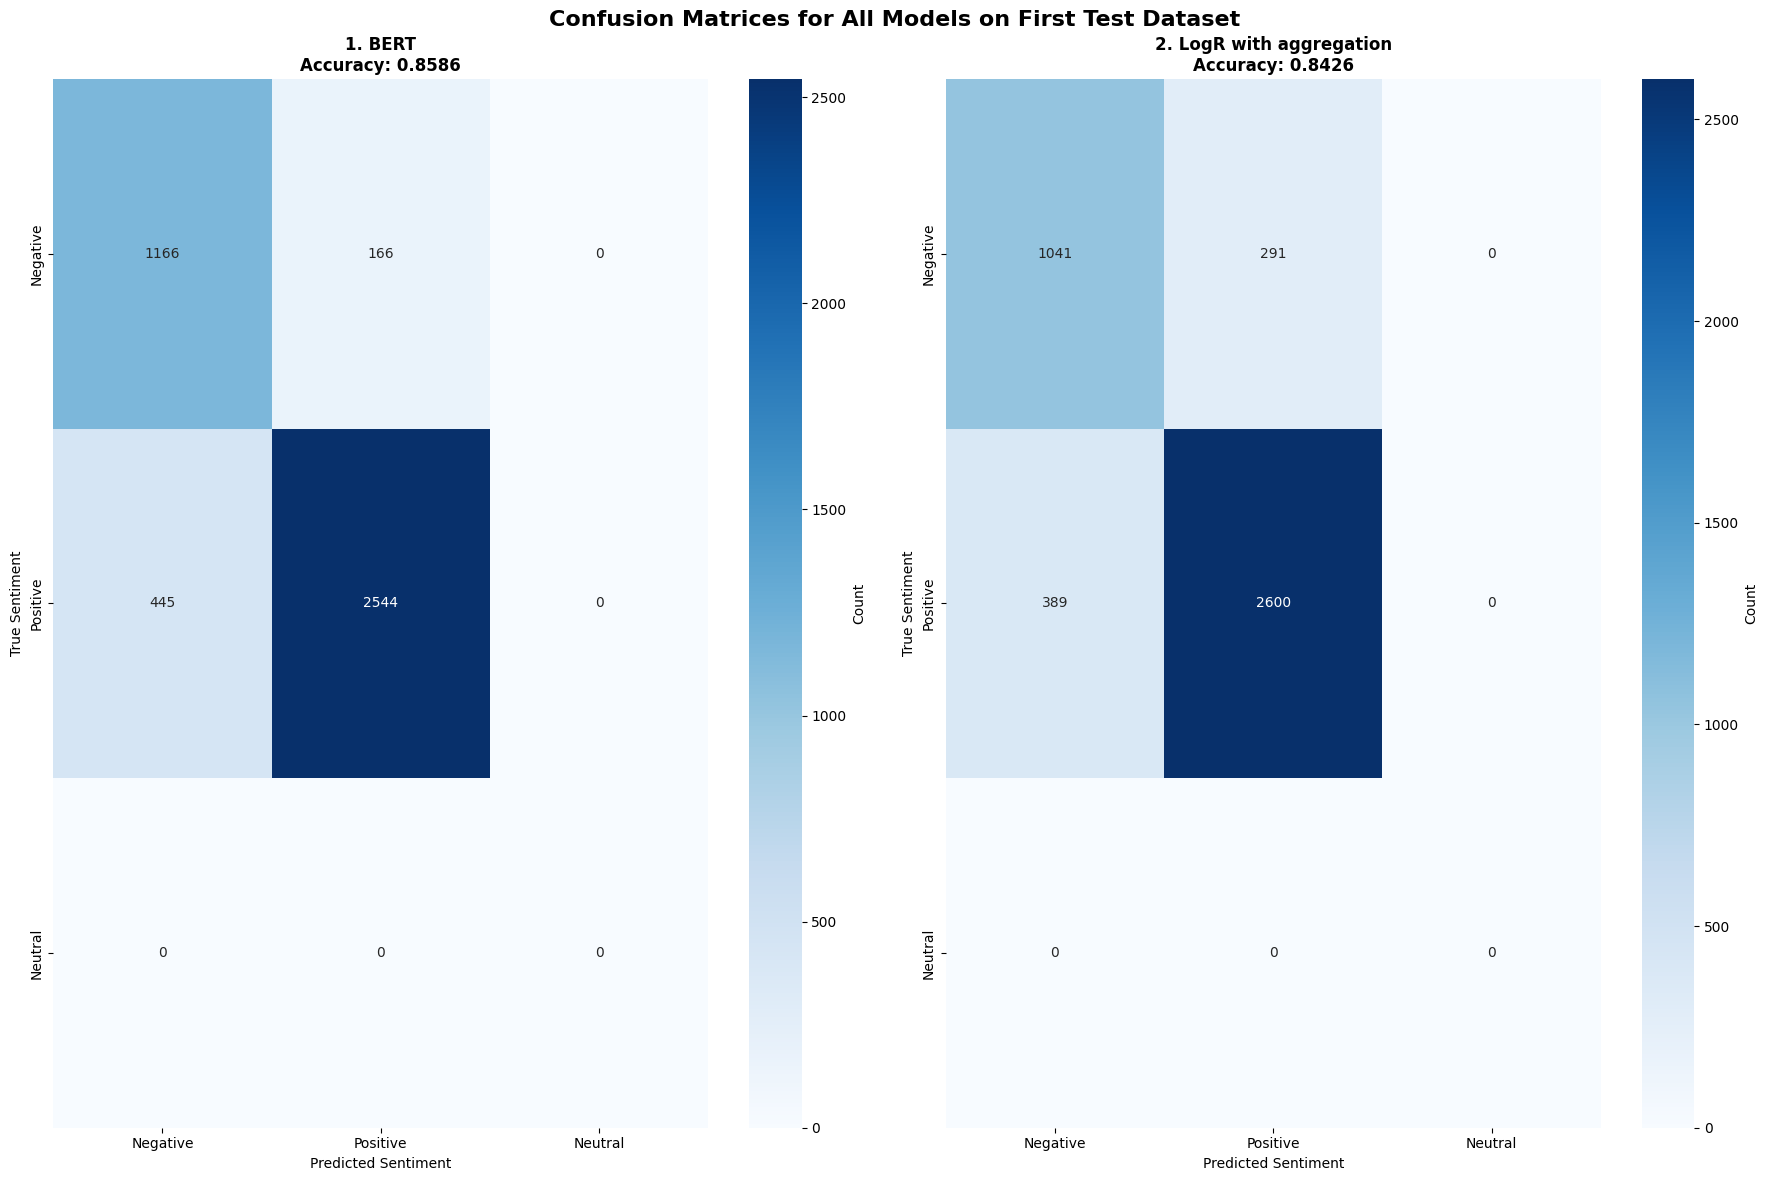

In [10]:
# confusion matrices for all models

## set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

## get unique labels for consistent plotting
labels = [0, 1, 2]
class_names = ['Negative', 'Positive', 'Neutral']

## create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models on First Test Dataset', fontsize=16, fontweight='bold')

## store all predictions and model names
predictions = {
    '1. BERT': y_pred_bert,
    '2. LogR with aggregation': y_pred_logr,
}

## store all CMs
CMs = {}

## calculate and plot confusion matrices
index = 0
for model_name, y_pred in predictions.items():
    ax = axes[index]
    
    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    CMs[model_name] = cm
    
    # calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # plot confusion matrix
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': 'Count'},
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    # set title with accuracy
    ax.set_title(f'{model_name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Sentiment', fontsize=10)
    ax.set_ylabel('True Sentiment', fontsize=10)
    
    # move to next subplot
    index += 1

plt.tight_layout()
plt.show()

In [11]:
# summary statistics
for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name}:")
    print(f"\tAccuracy: {accuracy:.4f}")


1. BERT:
	Accuracy: 0.8586

2. LogR with aggregation:
	Accuracy: 0.8426


## Prediction on the Second Test Dataset 

In [12]:
raw_X = df2.Review
raw_X

0                                  spend money elsewher
1     regular toast bread equal satisfi occasion pat...
2                           buffet bellagio far anticip
3                                      drink weak peopl
4                                     order not correct
                            ...                        
95                        think food flavor textur lack
96                                 appetit instantli go
97                 overal not impress would not go back
98    whole experi underwhelm think well go ninja su...
99    have not wast enough life pour salt wound draw...
Name: Review, Length: 100, dtype: object

In [13]:
y_true = df2.sentiment
y_true

0     0
1     1
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: sentiment, Length: 100, dtype: int64

In [14]:
# BERT transformer with BertTokenizer prediction
y_pred_bert = predict_bert_batch(
    raw_X.tolist(), 
    bert_model, 
    bert_tokenizer, 
    device, 
    max_length=MAX_LENGTH,
    batch_size=BERT_BATCH_SIZE
)

   BERT batches: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


In [15]:
# logistic regression with TfidfVectorizer prediction
y_pred_logr = []
for x in raw_X:  # use raw text, not vectorized
    y_pred_logr.append(get_aggregated_prediction(x, model=logR, model_name='logr'))

y_pred_logr = np.array(y_pred_logr)

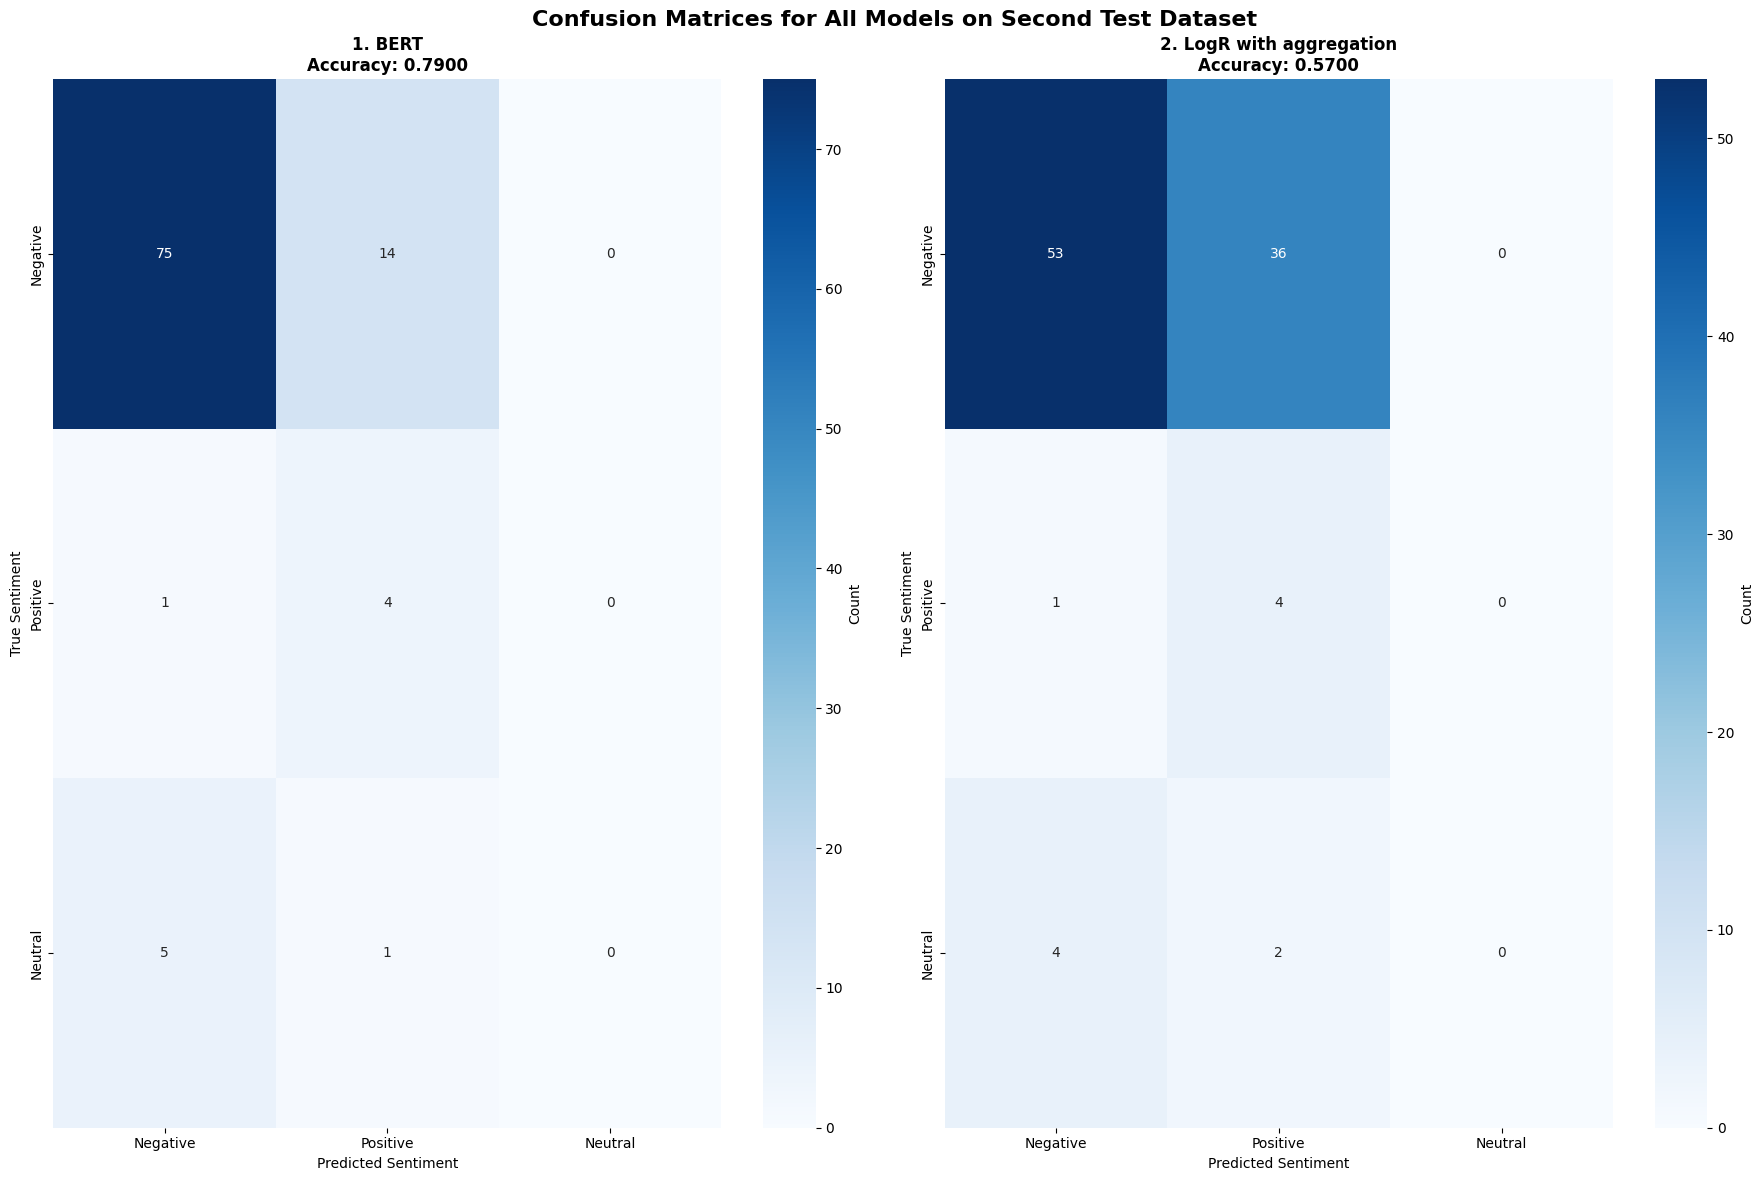

In [16]:
# confusion matrices for all models

## create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models on Second Test Dataset', fontsize=16, fontweight='bold')

## store all predictions and model names
predictions = {
    '1. BERT': y_pred_bert,
    '2. LogR with aggregation': y_pred_logr,
}

## store all CMs
CMs2 = {}

## calculate and plot confusion matrices
index = 0
for model_name, y_pred in predictions.items():
    ax = axes[index]
    
    # calculate confusion matrix
    cm2 = confusion_matrix(y_true, y_pred, labels=labels)
    CMs2[model_name] = cm2
    
    # calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # plot confusion matrix
    sns.heatmap(
        cm2, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': 'Count'},
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    # set title with accuracy
    ax.set_title(f'{model_name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Sentiment', fontsize=10)
    ax.set_ylabel('True Sentiment', fontsize=10)
    
    # move to next subplot
    index += 1

plt.tight_layout()
plt.show()

In [17]:
# summary statistics
for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name}:")
    print(f"\tAccuracy: {accuracy:.4f}")


1. BERT:
	Accuracy: 0.7900

2. LogR with aggregation:
	Accuracy: 0.5700


## Insight

Comparing BERT with normal prediction against Logistic Regression with aggregated prediction reveals that BERT consistently outperforms the aggregated LogR approach across both test datasets.

> On the first test dataset, both models achieve similar accuracy, with only a modest difference in performance.
>
> On the second test dataset, the performance gap becomes more pronounced: BERT achieves 79.00% accuracy compared to LogR with aggregated prediction at 57.00%.

These results validate that even with aggregated prediction enhancing Logistic Regression's performance, BERT remains the superior model. BERT's transformer architecture, which captures contextual relationships and understands semantic nuances across the entire sentence, provides a more robust approach to sentiment classification than the combination of traditional linear models with aggregated chunk-based predictions.

This notebook is done by `La Wun Nannda`.